In [11]:
import os
import math
import csv
from pathlib import Path
from datetime import timedelta

import cv2
import numpy as np
from tqdm import tqdm
from ultralytics import YOLO


In [12]:
# ---------- USER SETTINGS ----------
VIDEO_PATH = r"output_masked.mp4"   # ← change this
OUTPUT_DIR = Path("./exported_frames")            # images will be saved here
MODEL_WEIGHTS = "yolov8x-pose.pt"                 # auto-downloads if missing
CONF_THR = 0.25                                   # pose confidence
IMGSZ = 960                                       # inference size
DO_ANNOTATE = True                                # draw skeleton on exported frames
# -----------------------------------

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Open video & report stats
cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    raise RuntimeError(f"Could not open video: {VIDEO_PATH}")

FPS = cap.get(cv2.CAP_PROP_FPS)
FRAME_COUNT = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
WIDTH = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
HEIGHT = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
DURATION_SEC = FRAME_COUNT / FPS if FPS > 0 else 0.0

print(f"Resolution: {WIDTH} x {HEIGHT}")
print(f"FPS: {FPS:.3f}")
print(f"Total frames: {FRAME_COUNT}")
print(f"Duration: {DURATION_SEC:.2f} s")

# Helper to format timestamps hh:mm:ss.mmm
def fmt_timecode(frame_idx: int, fps: float) -> str:
    sec = frame_idx / max(fps, 1e-9)
    td = timedelta(seconds=sec)
    # Custom millisecond formatting (timedelta's default omits ms if zero)
    total_ms = int(round(sec * 1000))
    h = total_ms // (3600 * 1000)
    rem = total_ms % (3600 * 1000)
    m = rem // (60 * 1000)
    rem = rem % (60 * 1000)
    s = rem // 1000
    ms = rem % 1000
    return f"{h:02d}:{m:02d}:{s:02d}.{ms:03d}"

# Load YOLOv8 pose model
pose_model = YOLO(MODEL_WEIGHTS)
print("YOLOv8-Pose model loaded.")

Resolution: 1920 x 1080
FPS: 30.000
Total frames: 371
Duration: 12.37 s
YOLOv8-Pose model loaded.


In [8]:
# ## Real-time playback with YOLOv8-Pose
# Press 'q' to quit, 'p' to pause/resume.

# %%
cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    raise RuntimeError(f"Could not open video: {VIDEO_PATH}")

win_name = "YOLOv8 Pose — Live"
cv2.namedWindow(win_name, cv2.WINDOW_NORMAL)

# Target delay for real-time based on FPS (fallback to 1ms if FPS is 0/unknown)
delay_ms = int(1000 / FPS) if FPS and FPS > 0 else 1
delay_ms = max(1, delay_ms)

while True:
    ok, frame = cap.read()
    if not ok:
        break

    # Run pose inference
    # Using .predict for clarity; you can also do pose_model(frame)
    results = pose_model.predict(
        frame, conf=CONF_THR, imgsz=IMGSZ, verbose=False
    )
    annotated = results[0].plot()  # draws keypoints & skeleton

    cv2.imshow(win_name, annotated)
    key = cv2.waitKey(delay_ms) & 0xFF
    if key == ord('q'):
        break
    if key == ord('p'):
        # pause loop until 'p' pressed again
        while True:
            k2 = cv2.waitKey(30) & 0xFF
            if k2 == ord('p') or k2 == ord('q'):
                if k2 == ord('q'):
                    # quick exit if 'q' while paused
                    cap.release()
                    cv2.destroyAllWindows()
                    raise SystemExit
                break

cap.release()
cv2.destroyAllWindows()

Exporting frames: 100%|██████████| 369/369 [00:39<00:00,  9.32it/s]


Saved 369 frames to: C:\Users\yenul\PycharmProjects\YOLO_speed_tracker\exported_frames


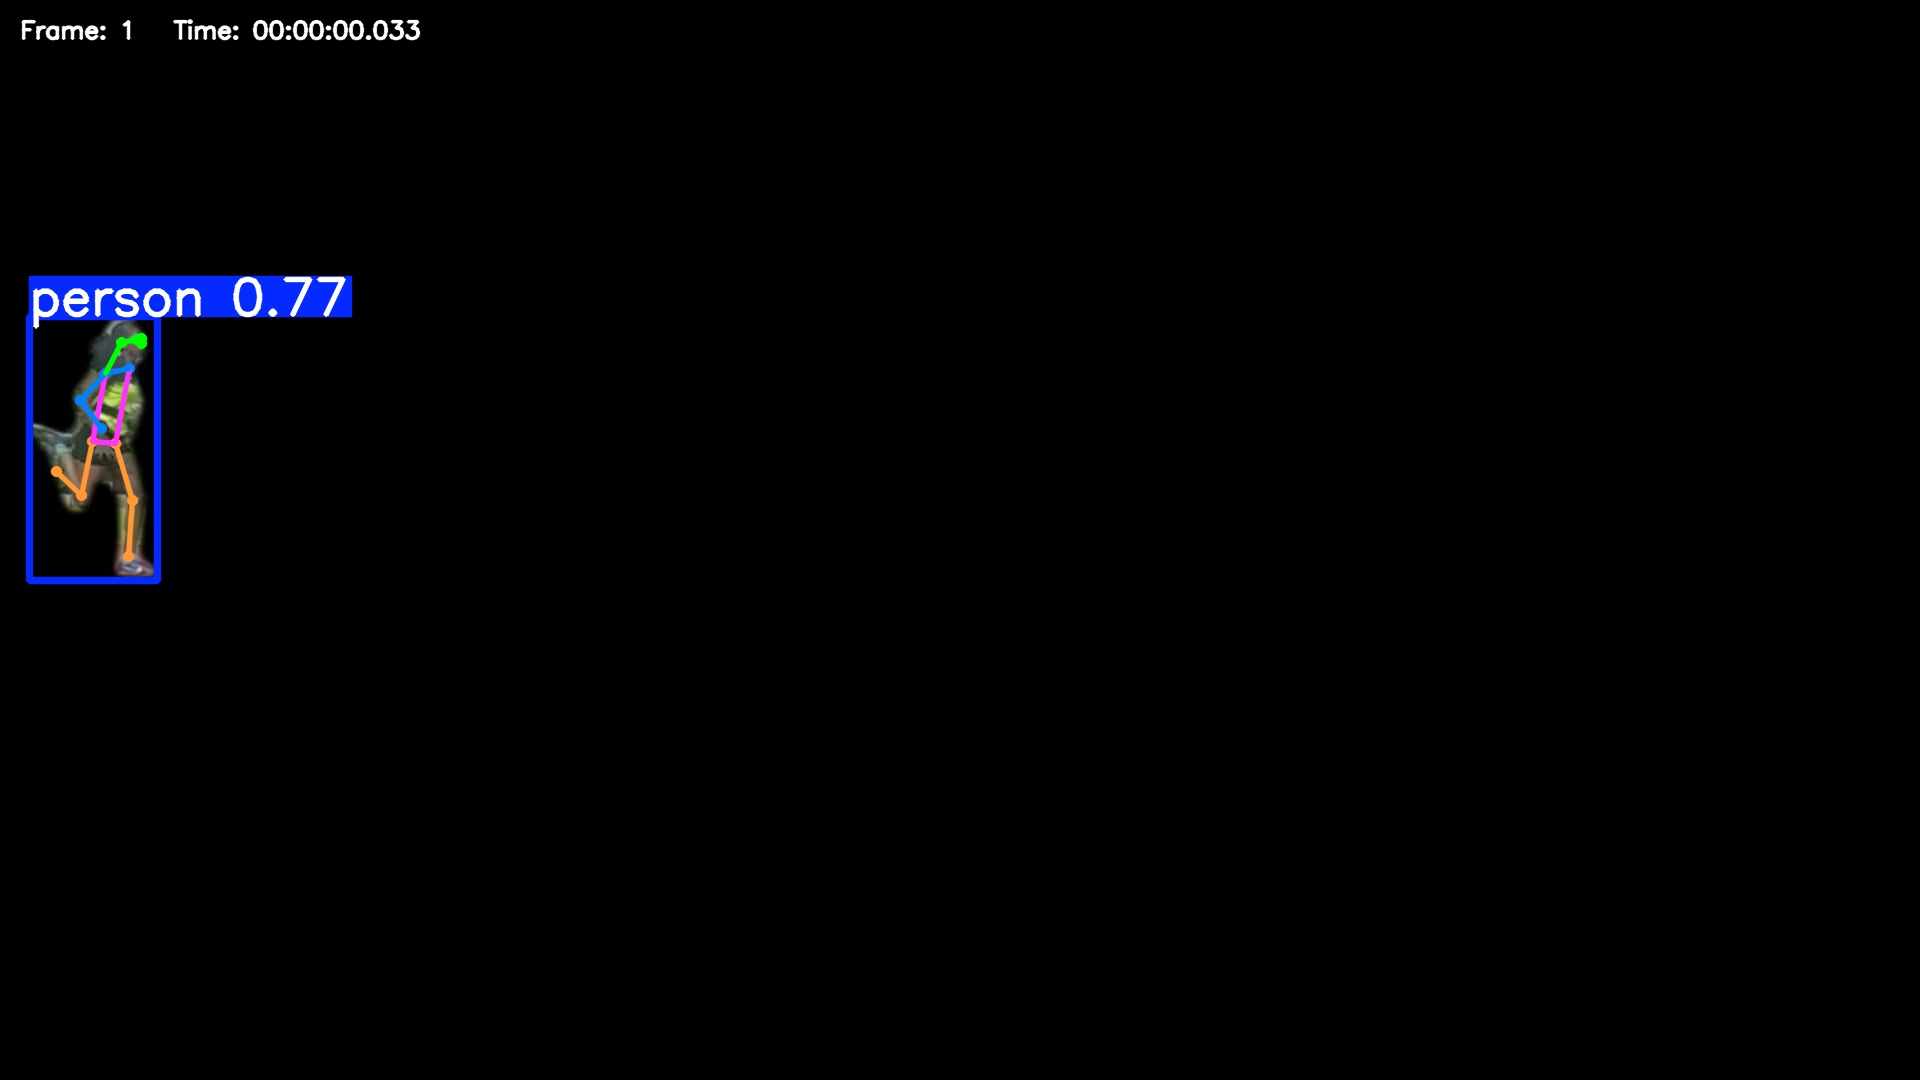

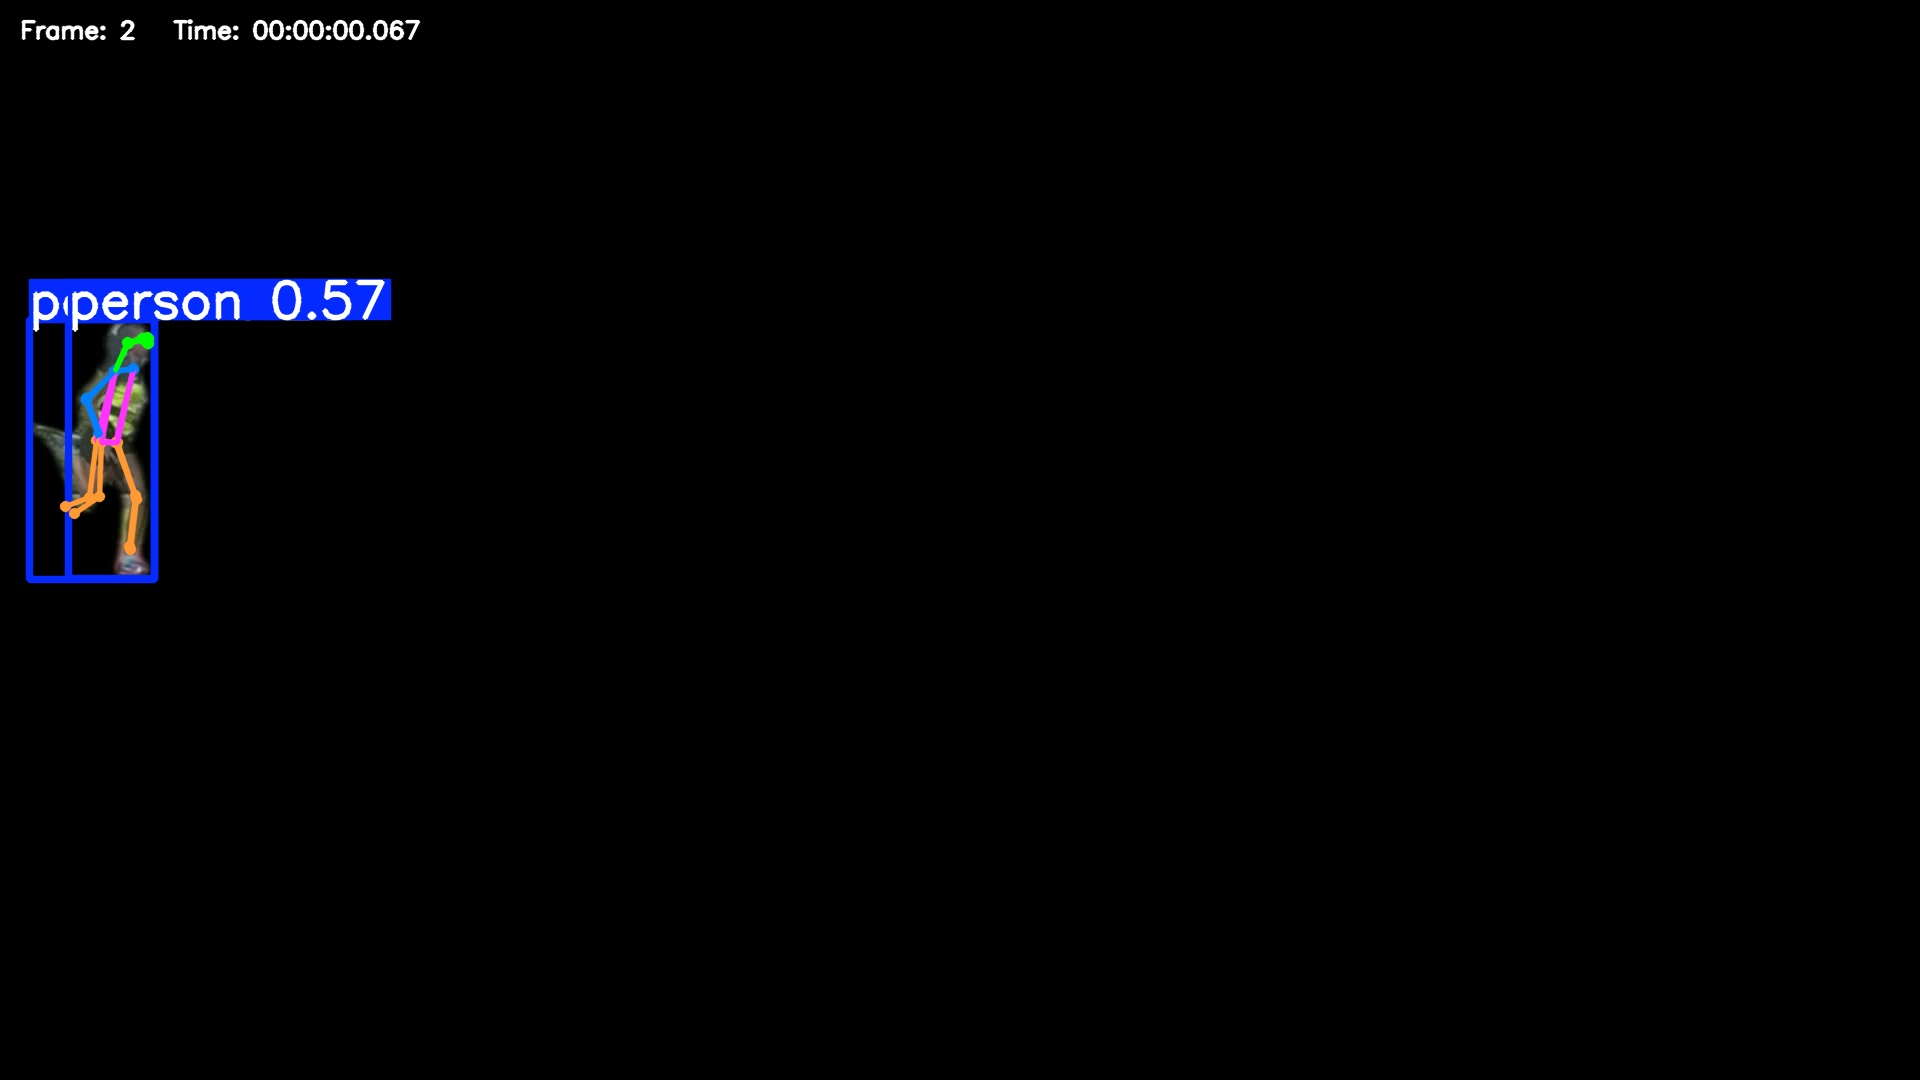

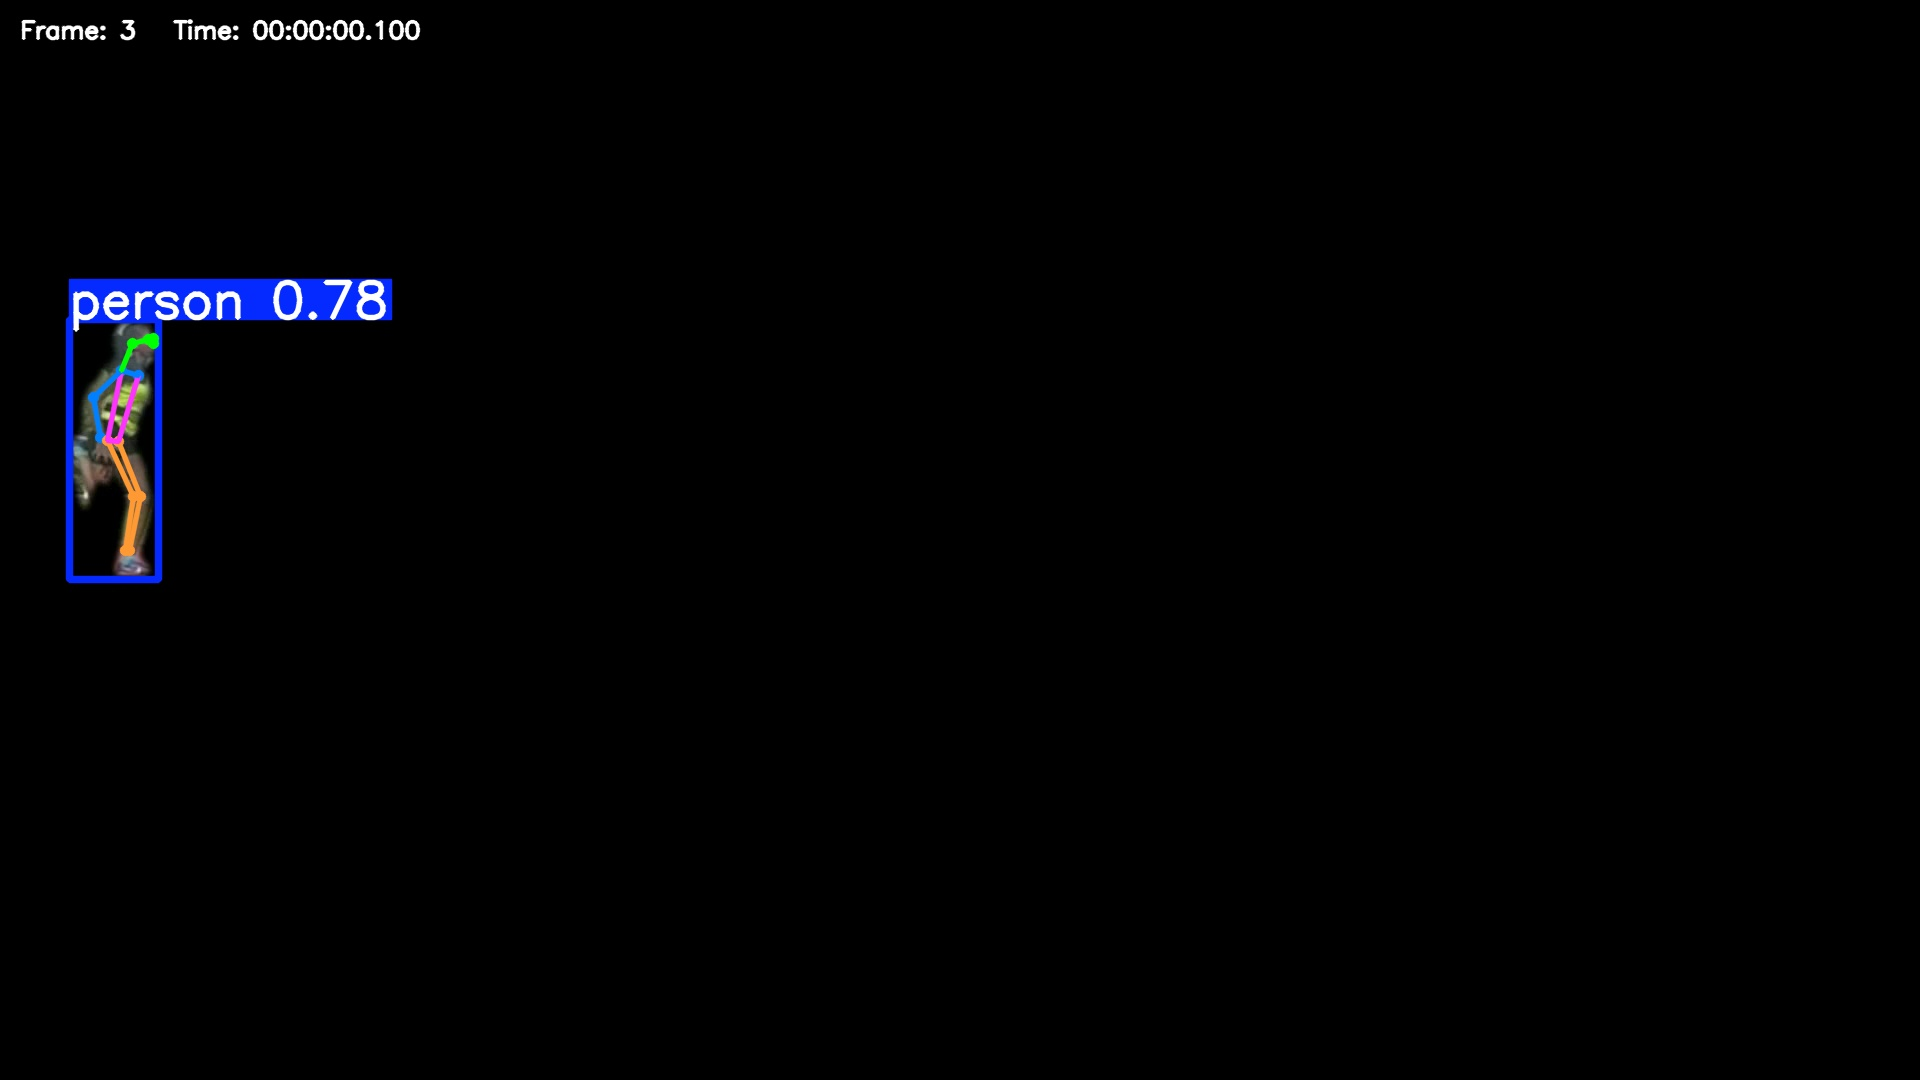

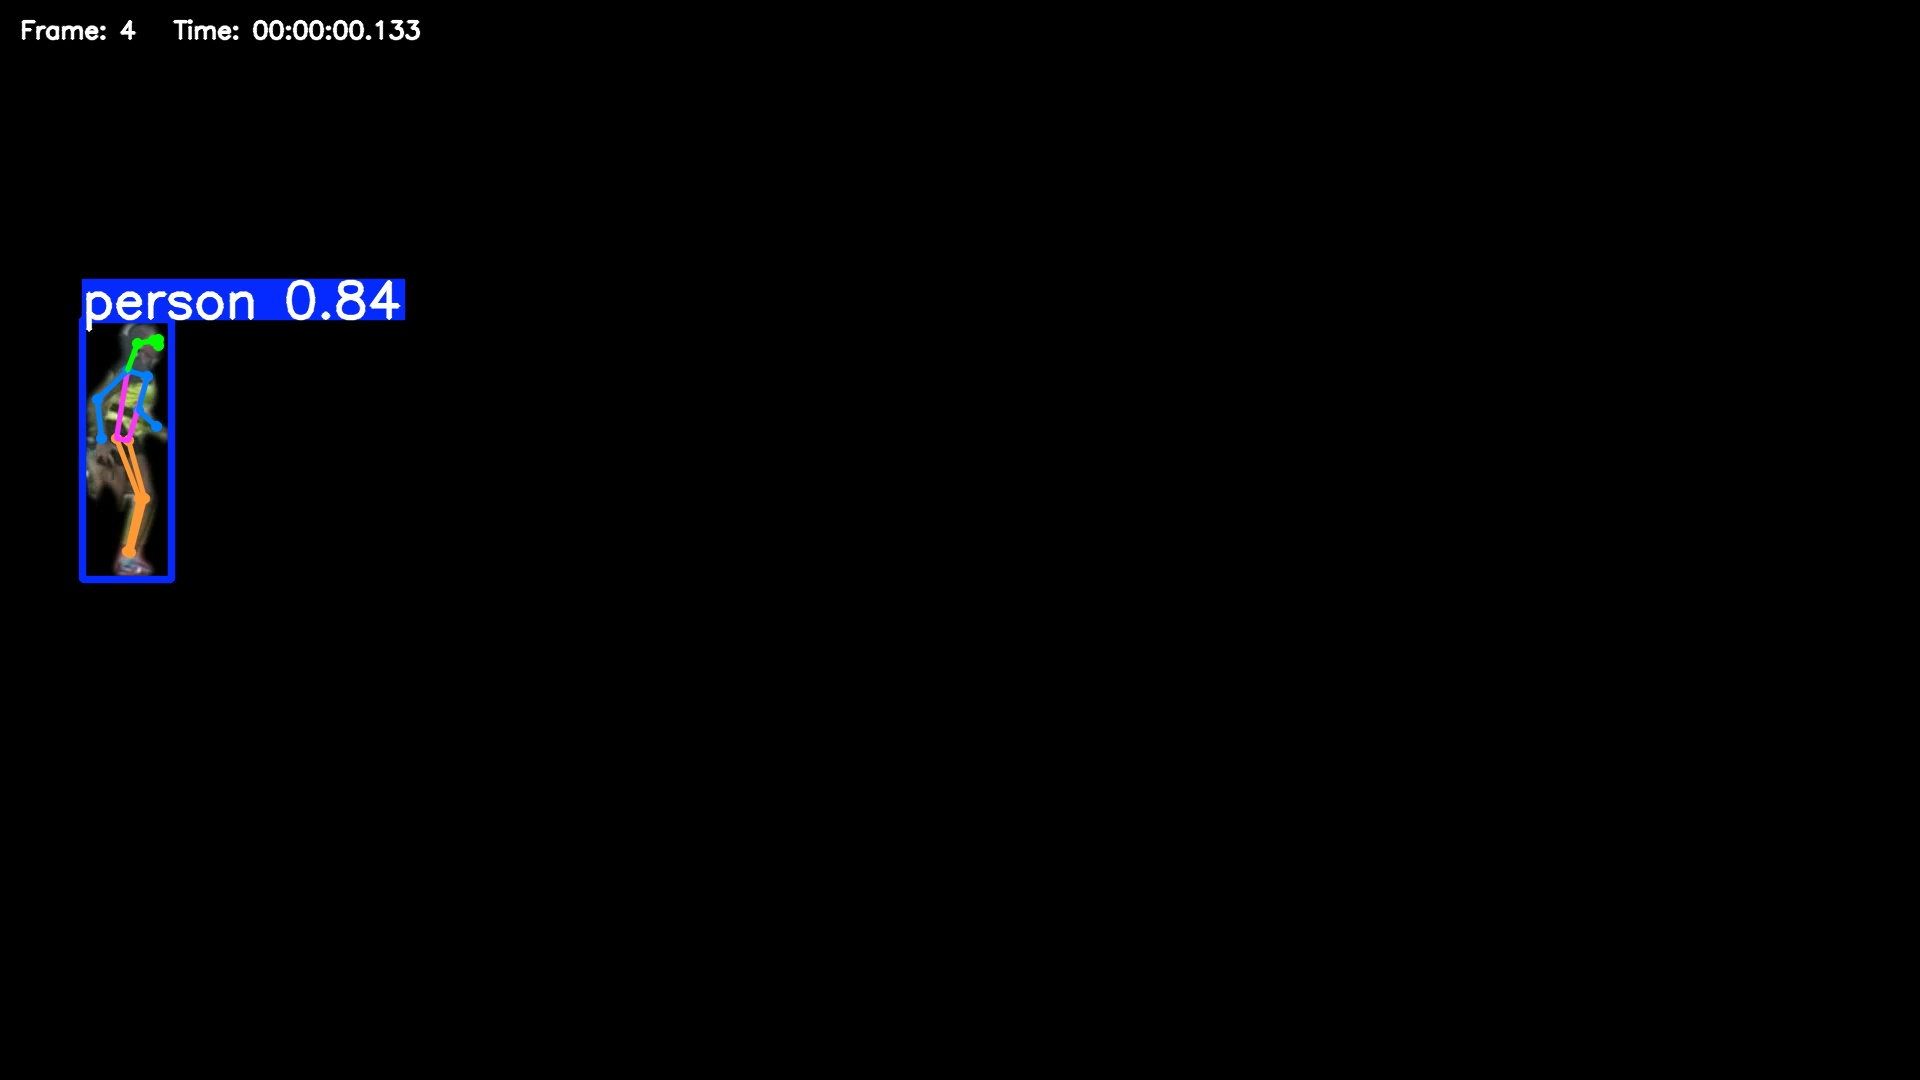

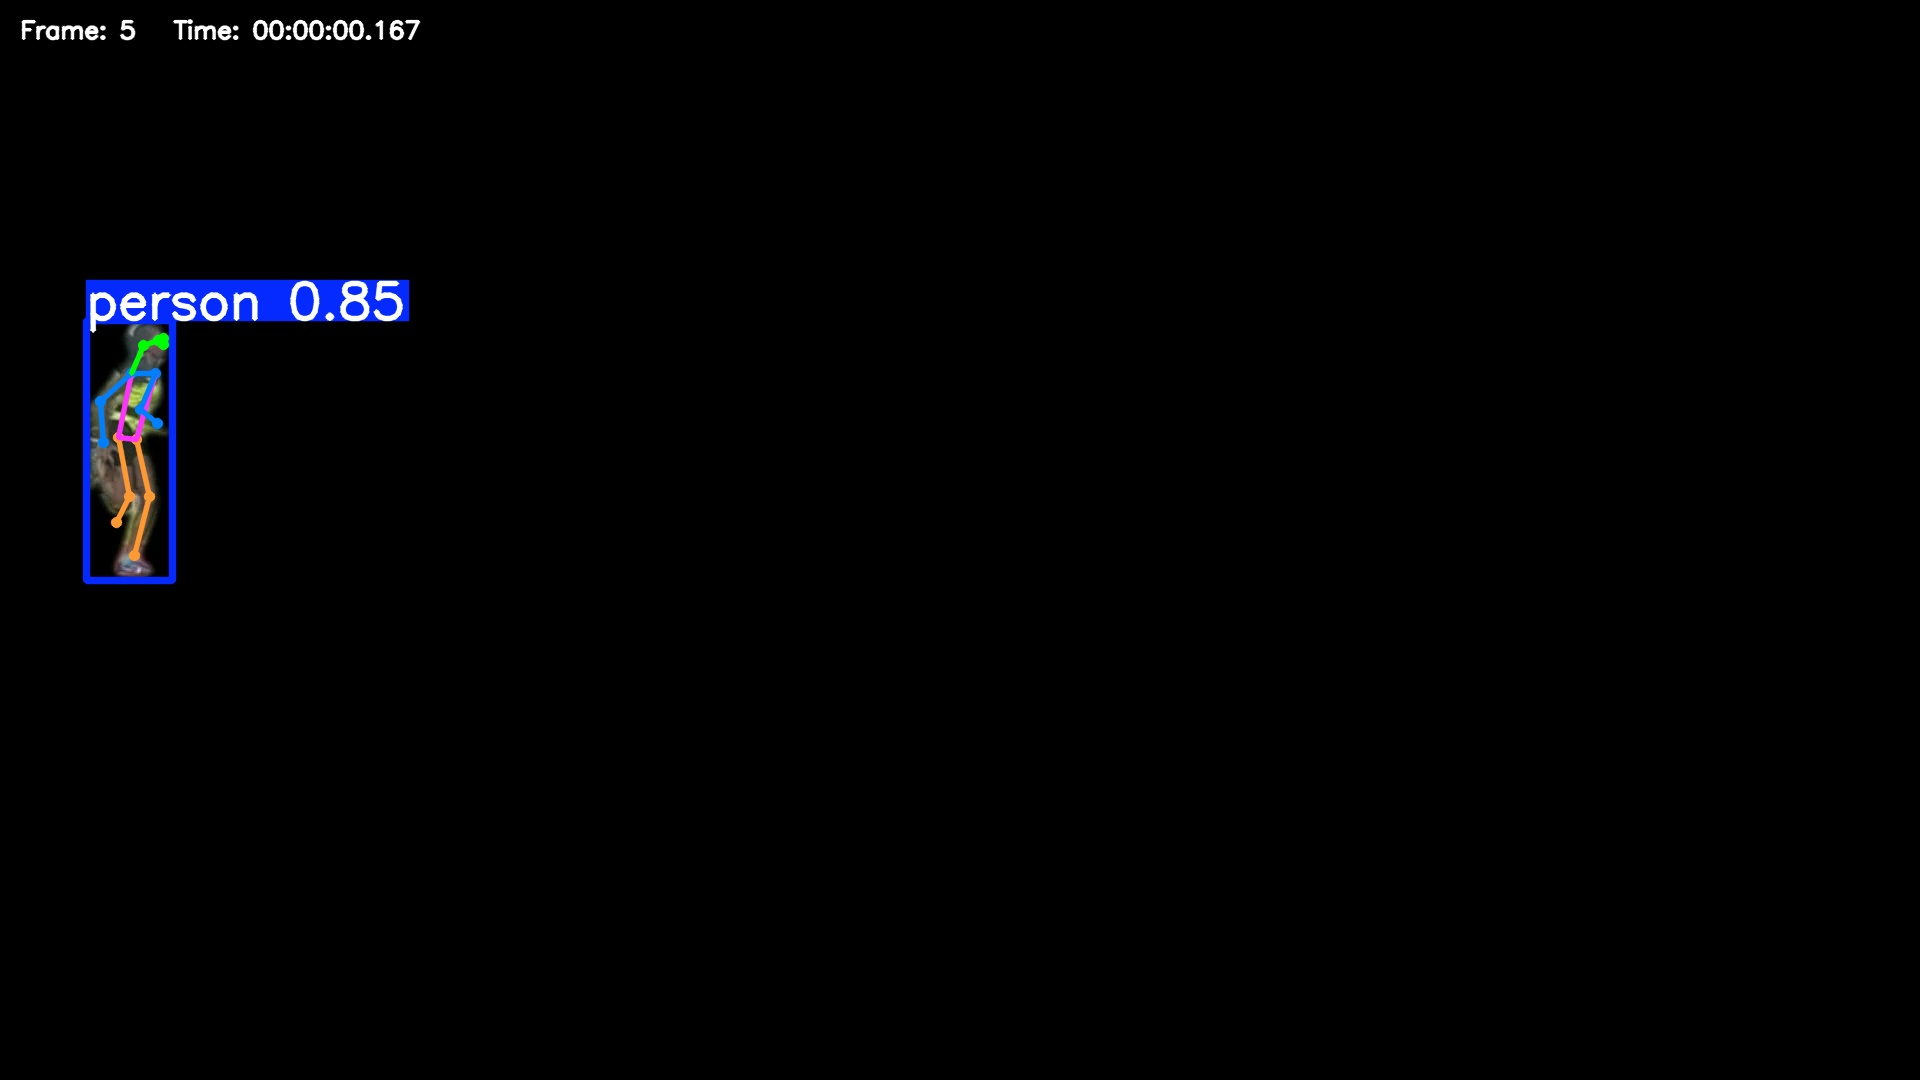

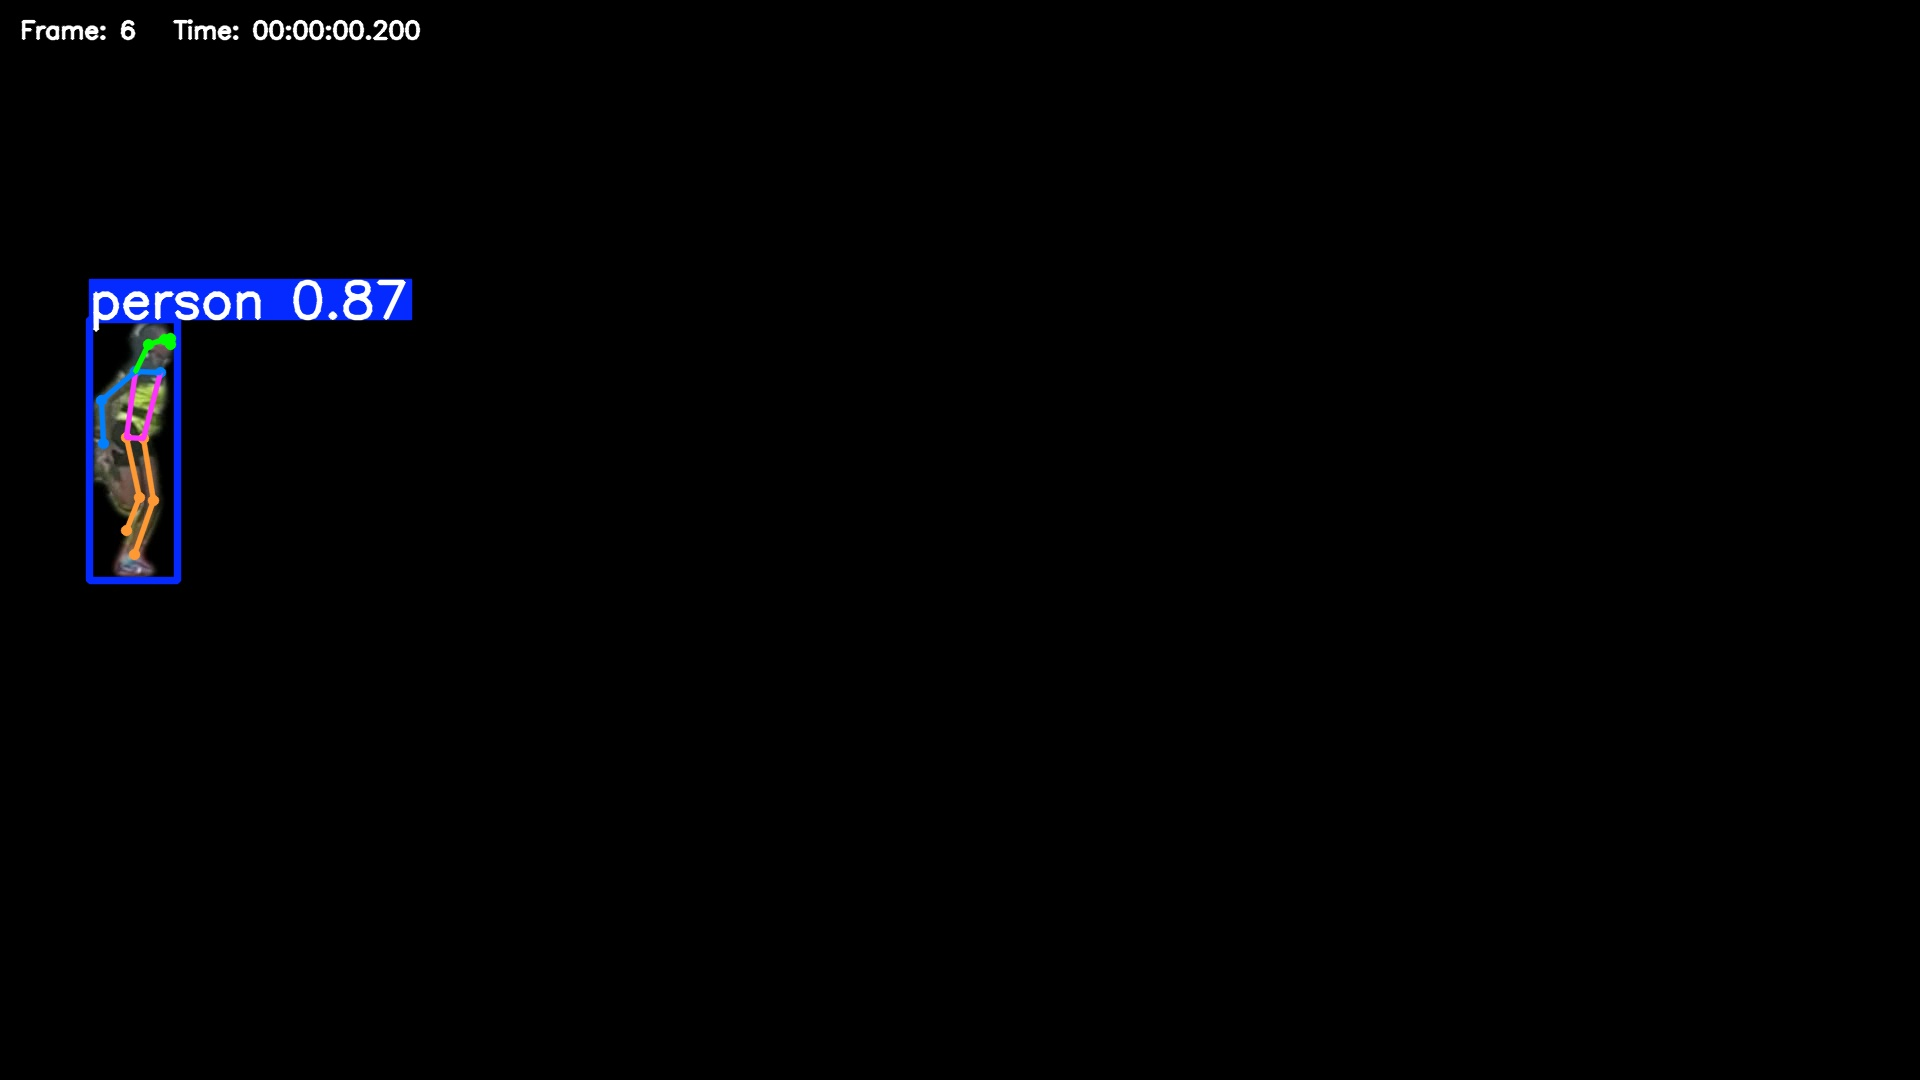

In [13]:
# %% [markdown]
# ## Export chosen frame range
# - Set START_FRAME and END_FRAME (inclusive)
# - Each saved image includes the frame number and timestamp
# - Optionally includes the pose skeleton if DO_ANNOTATE=True

# %%
# Choose your frame range (inclusive)
START_FRAME = 1
END_FRAME   = 369    # inclusive

# Clip to valid range
START_FRAME = max(0, START_FRAME)
END_FRAME = min(FRAME_COUNT - 1, END_FRAME)
if END_FRAME < START_FRAME:
    raise ValueError("END_FRAME must be >= START_FRAME")

# Prepare video for random access
cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    raise RuntimeError(f"Could not open video: {VIDEO_PATH}")

saved_records = []  # for CSV later

for fidx in tqdm(range(START_FRAME, END_FRAME + 1), desc="Exporting frames"):
    cap.set(cv2.CAP_PROP_POS_FRAMES, fidx)
    ok, frame = cap.read()
    if not ok:
        # if random seek fails, try reading sequentially
        ok2, frame2 = cap.read()
        if not ok2:
            print(f"[WARN] Could not read frame {fidx}, skipping.")
            continue
        frame = frame2

    # Optionally draw pose overlay on this frame
    out_img = frame.copy()
    if DO_ANNOTATE:
        results = pose_model.predict(
            out_img, conf=CONF_THR, imgsz=IMGSZ, verbose=False
        )
        out_img = results[0].plot()

    # Compose label (frame number + timestamp)
    timecode = fmt_timecode(fidx, FPS)
    label = f"Frame: {fidx}   Time: {timecode}"

    # Put a subtle box for readability
    (tw, th), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.8, 2)
    pad = 10
    cv2.rectangle(out_img, (10, 10), (10 + tw + 2*pad, 10 + th + 2*pad), (0, 0, 0), -1)
    cv2.putText(out_img, label, (10 + pad, 10 + th + pad),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2, cv2.LINE_AA)

    # Save
    out_path = OUTPUT_DIR / f"frame_{fidx:06d}.jpg"
    cv2.imwrite(str(out_path), out_img)

    saved_records.append({
        "frame": fidx,
        "time_seconds": fidx / max(FPS, 1e-9),
        "timecode": timecode,
        "image_path": str(out_path.resolve())
    })

cap.release()

print(f"Saved {len(saved_records)} frames to: {OUTPUT_DIR.resolve()}")
# Optional quick preview in-notebook (show up to 6)
try:
    from IPython.display import display
    from PIL import Image
    for rec in saved_records[:6]:
        display(Image.open(rec["image_path"]))
except Exception:
    pass


In [14]:
# ---------- Make a video from exported frames ----------
from pathlib import Path
import re
import cv2
from tqdm import tqdm

# Inputs
FRAMES_DIR = OUTPUT_DIR  # uses the same folder you wrote to earlier
OUTPUT_VIDEO = "exported_frames_compiled2.mp4"
FPS_OUT = float(FPS) if FPS and FPS > 0 else 30.0  # fall back to 30 if unknown

# Collect and sort frames numerically: frame_000001.jpg, frame_000002.jpg, ...
pattern = re.compile(r"frame_(\d+)\.(jpg|png)$", re.IGNORECASE)
frame_files = sorted(
    [p for p in Path(FRAMES_DIR).glob("frame_*.*") if pattern.search(p.name)],
    key=lambda p: int(pattern.search(p.name).group(1))
)

if not frame_files:
    raise RuntimeError(f"No frames found in {FRAMES_DIR}. Expected files like 'frame_000001.jpg'.")

# Read first frame to get frame size
first_img = cv2.imread(str(frame_files[0]))
if first_img is None:
    raise RuntimeError(f"Failed to read first frame: {frame_files[0]}")
height, width = first_img.shape[:2]
frame_size = (width, height)


# Try a few codecs for robustness
def make_writer(path, fps, size):
    for fourcc_str in ["mp4v", "avc1", "H264", "XVID"]:
        fourcc = cv2.VideoWriter_fourcc(*fourcc_str)
        writer = cv2.VideoWriter(path, fourcc, fps, size)
        if writer.isOpened():
            return writer, fourcc_str
    return None, None


writer, used_codec = make_writer(OUTPUT_VIDEO, FPS_OUT, frame_size)
if writer is None:
    raise RuntimeError("Could not open VideoWriter with any tested codec.")

# Write frames
for p in tqdm(frame_files, desc="Writing video"):
    img = cv2.imread(str(p))
    if img is None:
        print(f"[WARN] Skipping unreadable frame: {p}")
        continue
    if img.shape[1] != width or img.shape[0] != height:
        img = cv2.resize(img, frame_size, interpolation=cv2.INTER_AREA)
    writer.write(img)

writer.release()
print(f"Saved video: {OUTPUT_VIDEO}  | Frames: {len(frame_files)}  | FPS: {FPS_OUT}  | Codec: {used_codec}")


Writing video: 100%|██████████| 369/369 [00:03<00:00, 96.95it/s] 

Saved video: exported_frames_compiled.mp4  | Frames: 369  | FPS: 30.0  | Codec: mp4v


In [34]:
# %% [markdown]
# ## Save a CSV manifest for the exported frames

# %%
CSV_PATH = OUTPUT_DIR / "exported_frames_manifest.csv"

with open(CSV_PATH, "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=["frame", "time_seconds", "timecode", "image_path"])
    writer.writeheader()
    for row in saved_records:
        writer.writerow(row)

print(f"CSV written to: {CSV_PATH.resolve()}")


CSV written to: C:\Users\yenul\PycharmProjects\YOLO_speed_tracker\exported_frames\exported_frames_manifest.csv
